In [45]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import randint, uniform



# Baseline Model

In [2]:
df = pd.read_csv('../data/processed/dataset.csv').copy()
df.head()


,sales_agent,account,opportunity_status,manager,regional_office,sector,revenue,office_location,product,series,sales_price,duration,won,close_value
0,moses frase,cancity,completed,dustin brinkmann,central,retail,718.62,united states,gtx plus basic,gtx,1096.0,132.0,1,1054.0
1,darcel schlecht,isdom,completed,melvin marxen,central,medical,3178.24,united states,gtxpro,NaN,NaN,137.0,1,4514.0
2,darcel schlecht,cancity,completed,melvin marxen,central,retail,718.62,united states,mg special,mg,55.0,133.0,1,50.0
3,moses frase,codehow,completed,dustin brinkmann,central,software,2714.90,united states,gtx basic,gtx,550.0,135.0,1,588.0
4,zane levy,hatfan,completed,summer sewald,west,services,792.46,united states,gtx basic,gtx,550.0,128.0,1,517.0


X : Client details (account, sector, revenue, office_location) + 
     Sale details (sales_agent, product, deal_stage, duration , sector)

y: close_value

In [3]:
df.columns


Index(['sales_agent', 'account', 'opportunity_status', 'manager',
       'regional_office', 'sector', 'revenue', 'office_location', 'product',
       'series', 'sales_price', 'duration', 'won', 'close_value'],
      dtype='object')

In [4]:
df.describe()

,revenue,sales_price,duration,won,close_value
count,6711.000000,5564.000000,6711.000000,6711.0,6711.000000
mean,2520.212707,1876.395219,47.985397,1.0,1490.915512
std,2627.849922,2504.431797,41.057665,0.0,2320.670773
min,4.540000,55.000000,1.000000,1.0,0.000000
25%,647.180000,550.000000,8.000000,1.0,0.000000
50%,1698.200000,1096.000000,45.000000,1.0,472.000000
75%,3027.460000,3393.000000,85.000000,1.0,3225.000000
max,11698.030000,26768.000000,138.000000,1.0,30288.000000


## Data Preparation

### Duplicated

In [5]:
df.duplicated().sum()


np.int64(27)

### Missing Values

In [6]:
df.isnull().sum().sort_values(ascending=False) / len(df)


series                0.170913
sales_price           0.170913
sales_agent           0.000000
account               0.000000
opportunity_status    0.000000
manager               0.000000
regional_office       0.000000
sector                0.000000
revenue               0.000000
office_location       0.000000
product               0.000000
duration              0.000000
won                   0.000000
close_value           0.000000
dtype: float64

In [7]:
df = df.dropna(subset=['close_value']).reset_index(drop=True)


In [8]:
X = df.drop(columns=['close_value'])
y = df['close_value']


In [9]:
num_feat = ['revenue', 'sales_price', 'won', 'duration']
cat_feat = ['account', 'sector', 'office_location', 'sales_agent',
            'product', 'opportunity_status', 'manager', 'regional_office', 'series']


In [10]:
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

imputer_num.fit(df[num_feat])
df[num_feat] = imputer_num.transform(df[num_feat])

imputer_cat.fit(df[cat_feat])
df[cat_feat] = imputer_cat.transform(df[cat_feat])

print(imputer_num.statistics_)
print(imputer_cat.statistics_)


[2.52021271e+03 1.87639522e+03 1.00000000e+00 4.79853971e+01]
['hottechi' 'retail' 'united states' 'darcel schlecht' 'gtx basic'
 'completed' 'melvin marxen' 'central' 'gtx']


In [11]:
df.isnull().sum().sort_values(ascending=False) / len(df)


sales_agent           0.0
account               0.0
opportunity_status    0.0
manager               0.0
regional_office       0.0
sector                0.0
revenue               0.0
office_location       0.0
product               0.0
series                0.0
sales_price           0.0
duration              0.0
won                   0.0
close_value           0.0
dtype: float64

## Outliers

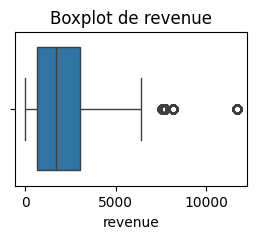

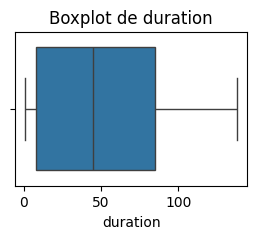

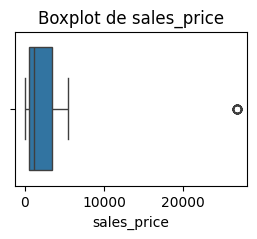

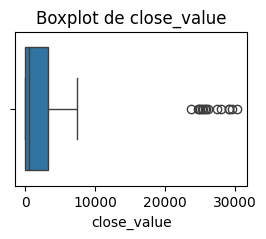

In [12]:
for col in ['revenue', 'duration', 'sales_price', 'close_value']:
    plt.figure(figsize=(3, 2))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot de {col}')
    plt.show()


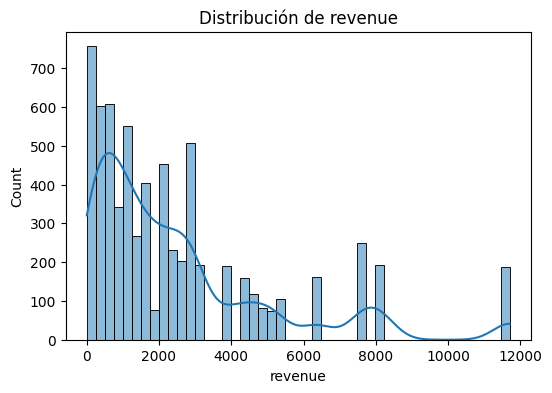

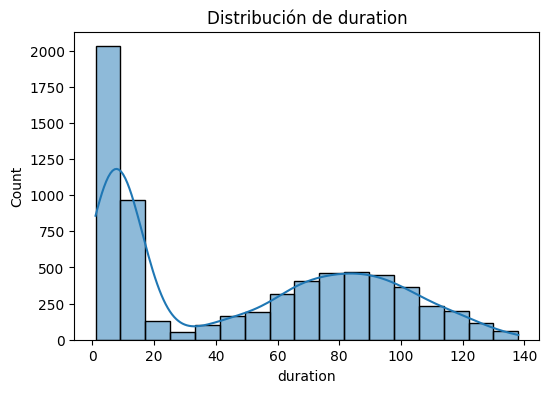

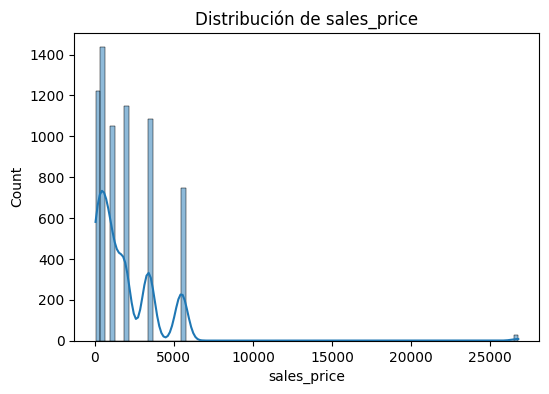

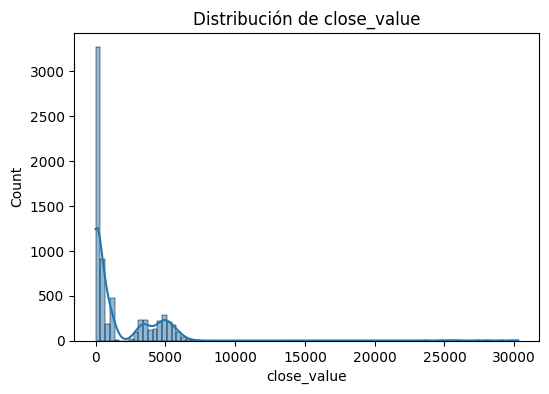

In [13]:
for col in ['revenue', 'duration', 'sales_price', 'close_value']:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


• Decision: I won't remove outliers because they make sense from a business perspective

• Decision: Because features like revenue and close_value contain true extreme values (not noise), and the distribution is highly skewed.

• Decision: I won't use StandardScaler because there is skewness and potential outliers


In [14]:
correlations = df.corr(numeric_only=True)[
    'close_value'].sort_values(ascending=False)
print(correlations.head(10))


close_value    1.000000
sales_price    0.606111
duration       0.049888
revenue        0.028136
won                 NaN
Name: close_value, dtype: float64


## Feature Scaling


In [15]:
scaler = RobustScaler()

scaler.fit(df[num_feat])
df[num_feat] = scaler.transform(df[num_feat])


In [16]:
df.head()


,sales_agent,account,opportunity_status,manager,regional_office,sector,revenue,office_location,product,series,sales_price,duration,won,close_value
0,moses frase,cancity,completed,dustin brinkmann,central,retail,-0.411540,united states,gtx plus basic,gtx,0.000000,1.129870,0.0,1054.0
1,darcel schlecht,isdom,completed,melvin marxen,central,medical,0.621792,united states,gtxpro,gtx,0.274497,1.194805,0.0,4514.0
2,darcel schlecht,cancity,completed,melvin marxen,central,retail,-0.411540,united states,mg special,mg,-0.366163,1.142857,0.0,50.0
3,moses frase,codehow,completed,dustin brinkmann,central,software,0.427135,united states,gtx basic,gtx,-0.192051,1.168831,0.0,588.0
4,zane levy,hatfan,completed,summer sewald,west,services,-0.380518,united states,gtx basic,gtx,-0.192051,1.077922,0.0,517.0


## Balancing

## Encoding


In [17]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

ohe.fit(df[cat_feat])

encoded_cat = ohe.transform(df[cat_feat])

encoded_columns = ohe.get_feature_names_out(cat_feat)

df_encoded_cat = pd.DataFrame(
    encoded_cat, columns=encoded_columns, index=df.index)

df_ohe = pd.concat([df.drop(columns=cat_feat), df_encoded_cat], axis=1)


In [18]:
correlations = df_ohe.corr(numeric_only=True)[
    'close_value'].sort_values(ascending=False)
print(correlations.head(10))


close_value                    1.000000
sales_price                    0.606111
product_gtx plus pro           0.310480
product_gtxpro                 0.307140
series_gtx                     0.110048
product_mg advanced            0.104734
sales_agent_darcel schlecht    0.076769
manager_rocco neubert          0.051993
duration                       0.049888
sales_agent_elease gluck       0.047944
Name: close_value, dtype: float64


In [19]:
df_ohe.shape


(6711, 156)

In [20]:
df_ohe.columns


Index(['revenue', 'sales_price', 'duration', 'won', 'close_value',
       'account_betasoloin', 'account_betatech', 'account_bioholding',
       'account_bioplex', 'account_blackzim',
       ...
       'product_mg special', 'manager_celia rouche',
       'manager_dustin brinkmann', 'manager_melvin marxen',
       'manager_rocco neubert', 'manager_summer sewald',
       'regional_office_east', 'regional_office_west', 'series_gtx',
       'series_mg'],
      dtype='object', length=156)

In [21]:
ohe.categories_


[array(['acme corporation', 'betasoloin', 'betatech', 'bioholding',
        'bioplex', 'blackzim', 'bluth company', 'bubba gump', 'cancity',
        'cheers', 'codehow', 'condax', 'conecom', 'dalttechnology',
        'dambase', 'domzoom', 'doncon', 'donquadtech', 'dontechi',
        'donware', 'fasehatice', 'faxquote', 'finhigh', 'finjob',
        'funholding', 'ganjaflex', 'gekko & co',
        'genco pura olive oil company', 'globex corporation', 'gogozoom',
        'golddex', 'goodsilron', 'green-plus', 'groovestreet', 'hatfan',
        'hottechi', 'initech', 'inity', 'isdom', 'iselectrics', 'j-texon',
        'kan-code', 'kinnamplus', 'konex', 'konmatfix', 'labdrill',
        'lexiqvolax', 'massive dynamic', 'mathtouch', 'nam-zim', 'newex',
        'ontomedia', 'opentech', 'plexzap', 'plusstrip', 'plussunin',
        'rangreen', 'rantouch', 'ron-tech', 'rundofase', 'scotfind',
        'scottech', 'silis', 'singletechno', 'sonron', 'stanredtax',
        'statholdings', 'streethex', 

## Model


In [22]:
X_ohe = df_ohe.drop(columns=['close_value'])
y = df_ohe['close_value']


### Linear Regression Model

In [23]:
model_LR = LinearRegression()


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ohe, y, test_size=0.3, random_state=42)
cv_results_LR = cross_validate(model_LR, X_train, y_train, cv=5)
cv_results_LR['test_score'].mean()


np.float64(0.44958901573270466)

In [25]:
model_LR.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
y_pred = model_LR.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


R2 Score: 0.38665612018832163
MAE: 1166.3326991775884
RMSE: 3184560.780826366


### Random Forest Regressor Model

In [27]:
model_RFR = RandomForestRegressor(random_state=42)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ohe, y, test_size=0.3, random_state=42)
cv_results_LR = cross_validate(model_RFR, X_train, y_train, cv=5)
cv_results_LR['test_score'].mean()


np.float64(0.3853464489327548)

In [29]:
model_RFR.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_pred_RFR = model_RFR.predict(X_test)


In [31]:
print("R2 Score:", r2_score(y_test, y_pred_RFR))
print("MAE:", mean_absolute_error(y_test, y_pred_RFR))
print("RMSE:", mean_squared_error(y_test, y_pred_RFR))


R2 Score: 0.35371563997772604
MAE: 1100.6997005899184
RMSE: 3355592.0160486996


### Gradient Boosting Regressor

In [32]:
model_GBR = GradientBoostingRegressor(random_state=42)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ohe, y, test_size=0.3, random_state=42)
cv_results_GBR = cross_validate(model_GBR, X_train, y_train, cv=5)
cv_results_GBR['test_score'].mean()


np.float64(0.4421111197097839)

In [34]:
model_GBR.fit(X_train, y_train)

y_pred_GBR = model_GBR.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred_GBR))
print("MAE:", mean_absolute_error(y_test, y_pred_GBR))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_GBR)))


R2 Score: 0.40240106312970014
MAE: 1115.4818254454212
RMSE: 1761.4797756239122


Summary 

| Model                     | CV R² (Train) | Test R² | Test MAE | Test RMSE |
|--------------------------|---------------|---------|----------|-----------|
| **Linear Regression**     | 0.45          | 0.39    | 1166.33  | 1783.44   |
| **Random Forest Regressor** | 0.39        | 0.35    | **1100.70** | 1832.49   |
| **Gradient Boosting Regressor** | **0.44** | **0.40**| 1115.48  | **1761.48** |

 **Linear Regression** provides a solid baseline with a CV R² of 0.45 but shows the highest MAE among all models.
 
 **Random Forest Regressor** achieves the **lowest MAE**, but its lower R² suggests it may not generalize as well as the other models.
 
 **Gradient Boosting Regressor** shows the **best overall performance**, with strong R² scores in both CV and test sets, and the lowest RMSE, making it the most promising model so far.

# Pipeline


In [35]:
X = df.drop(columns=['close_value' ])
y = df['close_value']

num_feat = ['revenue', 'sales_price', 'duration' , 'won']
cat_feat = ['account', 'sector', 'office_location', 'sales_agent',
            'product',  'manager' ,'opportunity_status', 'regional_office', 'series']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer, num_feat),
    ('cat', cat_transformer, cat_feat)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

cv_results = cross_validate(
    pipeline, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2: {cv_results['train_score'].mean():.4f}")
print(f"Test CV R2: {cv_results['test_score'].mean():.4f}")


Train CV R2: 0.6118
Test CV R2: 0.4421


In [36]:
base_train_r2 = cv_results['train_score'].mean()
base_test_r2 = cv_results['test_score'].mean()

In [37]:
pipeline.fit(X_train, y_train)  

y_pred = pipeline.predict(X_test)

print('R2 Score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred))

R2 Score: 0.40240106312970014
MAE: 1115.4818254454212
RMSE: 3102810.9999320684


## Feature Importance Extraction using Random Forest

To identify which variables most influence the target (`close_value`), we trained a Random Forest Regressor and extracted feature importances from its fitted model.


In [38]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline_rf.fit(X_train, y_train)

importances = pipeline_rf.named_steps['model'].feature_importances_
features = pipeline_rf.named_steps['preprocessor'].transform(X_train).shape[1]

ohe = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cols = ohe.get_feature_names_out(cat_feat)
all_features = np.concatenate([num_feat, encoded_cols])

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)


,feature,importance
1,sales_price,0.455989
2,duration,0.134988
0,revenue,0.073543
154,series_mg,0.014456
153,series_gtx,0.011316
127,sales_agent_markita hansen,0.010077
144,product_mg advanced,0.008713
118,sales_agent_elease gluck,0.008474
133,sales_agent_rosalina dieter,0.005677
117,sales_agent_donn cantrell,0.005458


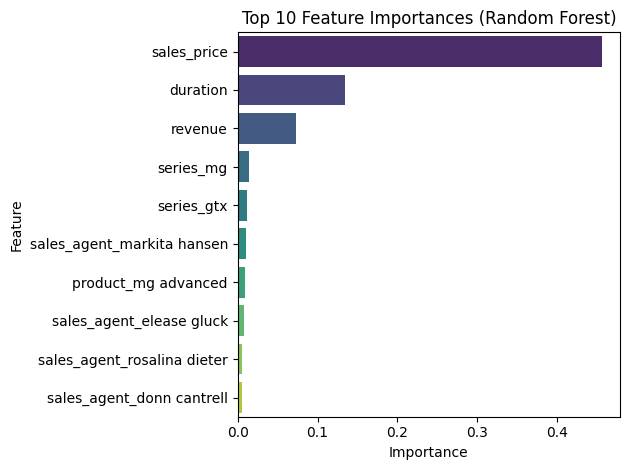

In [44]:
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance_df.head(10),
    hue="feature",
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [39]:
top_n = 10

top_features = feature_importance_df['feature'].head(top_n).tolist()

new_num_feat = [feat for feat in num_feat if feat in top_features]
new_cat_feat = [feat for feat in cat_feat if any(feat in name for name in top_features)]

print("Numerical:", new_num_feat)
print("Categorical:", new_cat_feat)


Numerical: ['revenue', 'sales_price', 'duration']
Categorical: ['sales_agent', 'product', 'series']


In [40]:
new_num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

new_cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

new_preprocessor = ColumnTransformer([
    ('num', new_num_transformer, new_num_feat),
    ('cat', new_cat_transformer, new_cat_feat)
])

In [41]:
reduced_pipeline = Pipeline([
    ('preprocessor', new_preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

reduced_cv_results = cross_validate(
    reduced_pipeline, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2 (reduced): {reduced_cv_results['train_score'].mean():.4f}")
print(f"Test CV R2 (reduced): {reduced_cv_results['test_score'].mean():.4f}")


reduced_pipeline.fit(X_train, y_train)


reduced_y_pred = reduced_pipeline.predict(X_test)
print("R2 (reduced):", r2_score(y_test, reduced_y_pred))
print("MAE (reduced):", mean_absolute_error(y_test, reduced_y_pred))
print("RMSE (reduced):", mean_squared_error(y_test, reduced_y_pred))

Train CV R2 (reduced): 0.6098
Test CV R2 (reduced): 0.4486
R2 (reduced): 0.4063642339889567
MAE (reduced): 1111.1478243839083
RMSE (reduced): 3082233.704060171


### Model Comparison: Full vs. Top 10 Features

| Metric          | Full Model | Reduced Model (Top 10) |
|-----------------|------------|-------------------------|
| Train CV R²     | 0.6118     | 0.6098                  |
| Test CV R²      | 0.4421     | 0.4486 ✅                |
| Test R²         | 0.4024     | 0.4064 ✅                |
| MAE             | 1115.48    | 1111.15 ✅               |
| RMSE            | 3,102,811  | 3,082,234 ✅             |

The reduced model with only the top 10 most important features achieves nearly identical (and slightly better) performance compared to the full model. This simplifies the model while maintaining predictive power.


## Feature Selection via Lasso Regression

To further reduce model complexity and enhance interpretability, we applied Lasso Regression (L1 regularization), which automatically selects the most relevant features by shrinking the less important coefficients to zero.

We used `LassoCV` with 5-fold cross-validation to automatically tune the regularization strength (`alpha`). The pipeline was trained using the same features and preprocessing steps as in the full model.

Once trained, we extracted the model coefficients to identify which features were retained (i.e., non-zero weights). Only a small subset of variables carried predictive power, confirming that many of the original features can be safely discarded.


In [46]:
# Lasso pipeline
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LassoCV(cv=5, random_state=42))
])


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

cv_results_lasso = cross_validate(
    pipeline_lasso, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

pipeline_lasso.fit(X_train, y_train)

y_pred_lasso = pipeline_lasso.predict(X_test)

print(f"Train CV R²: {cv_results_lasso['train_score'].mean():.4f}")
print(f"Test CV R²: {cv_results_lasso['test_score'].mean():.4f}")
print("R2 (Test):", r2_score(y_test, y_pred_lasso))
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", mean_squared_error(y_test, y_pred_lasso))


Train CV R²: 0.4907
Test CV R²: 0.4745
R2 (Test): 0.40372387005860577
MAE: 1135.248479377936
RMSE: 3095942.815207226


In [48]:
lasso_model = pipeline_lasso.named_steps['model']
coef = lasso_model.coef_

ohe = pipeline_lasso.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_cols = ohe.get_feature_names_out(cat_feat)
all_feature_names = np.concatenate([num_feat, encoded_cat_cols])

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coef': coef
}).sort_values(by='coef', key=abs, ascending=False)


selected_features = coef_df[coef_df['coef'] != 0]
selected_features.head(10)


,feature,coef
143,product_gtxpro,1888.106410
1,sales_price,1795.884019
2,duration,253.367709
152,regional_office_west,72.462102
154,series_mg,-17.307466
144,product_mg advanced,-14.494283
0,revenue,-10.600806


### Model Performance – Lasso vs Others

The Lasso regression model retained only 7 out of the many encoded features. Despite its simplicity, it achieved comparable performance to the full and reduced models:

| Metric       | Full Model | Reduced (Top 10) | Lasso (7 features) |
|--------------|------------|------------------|---------------------|
| Train CV R²  | 0.6118     | 0.6098           | 0.4907              |
| Test CV R²   | 0.4421     | 0.4486 ✅         | 0.4745 ✅            |
| Test R²      | 0.4024     | 0.4064 ✅         | 0.4037 ✅            |
| MAE          | 1115.48    | 1111.15 ✅        | 1135.25             |
| RMSE         | 3,102,811  | 3,082,234 ✅      | 3,095,943 ✅         |

While the Lasso model slightly increases MAE, it achieves the **highest CV R² on the test set**, suggesting better generalization and more robustness with fewer features. This validates the importance of **automatic feature selection**.


## Final Model: Gradient Boosting with Lasso-Selected Features

To combine interpretability and predictive power, we use the features selected by Lasso Regression and train a final model using Gradient Boosting Regressor.

This hybrid approach leverages:
- Lasso's ability to filter out irrelevant features.
- Gradient Boosting's superior performance in non-linear regression tasks.

This final pipeline aims to achieve strong generalization performance with a simplified, robust set of input variables.


In [52]:
lasso_coefs = pipeline_lasso.named_steps['model'].coef_
selected_indices = np.where(lasso_coefs != 0)[0]
selected_features = np.array(all_features)[selected_indices]

final_num_feat = [feat for feat in num_feat if feat in selected_features]
final_cat_feat = [feat for feat in cat_feat if any(feat in name for name in selected_features)]

print("Numerical:", final_num_feat)
print("Categorical:", final_cat_feat)


Numerical: ['revenue', 'sales_price', 'duration']
Categorical: ['product', 'regional_office', 'series']


In [53]:
final_num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

final_cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

final_preprocessor = ColumnTransformer([
    ('num', final_num_transformer, final_num_feat),
    ('cat', final_cat_transformer, final_cat_feat)
])

final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])


In [54]:
final_cv_results = cross_validate(
    final_pipeline, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2 (final): {final_cv_results['train_score'].mean():.4f}")
print(f"Test CV R2 (final): {final_cv_results['test_score'].mean():.4f}")


final_pipeline.fit(X_train, y_train)
final_y_pred = final_pipeline.predict(X_test)

print("R2 (final):", r2_score(y_test, final_y_pred))
print("MAE (final):", mean_absolute_error(y_test, final_y_pred))
print("RMSE (final):", mean_squared_error(y_test, final_y_pred))


Train CV R2 (final): 0.6046
Test CV R2 (final): 0.4286
R2 (final): 0.38260999276225394
MAE (final): 1113.9172259408235
RMSE (final): 3205568.797926394


### Model Performance Comparison

| Metric          | Full GBoost Model | Top 10 Features (RF) | Lasso Regression | Final Model (Lasso + GBoost) |
|-----------------|------------------:|----------------------:|------------------:|------------------------------:|
| Train CV R²     | 0.6118            | 0.6098                | 0.4907            | 0.6046                        |
| Test CV R²      | 0.4421            | 0.4486 ✅              | 0.4745 ✅          | 0.4286                        |
| Test R²         | 0.4024            | 0.4064 ✅              | 0.4037 ✅          | 0.3826                        |
| MAE             | 1115.48           | 1111.15 ✅             | 1135.25           | 1113.92 ✅                     |
| RMSE            | 3,102,811         | 3,082,234 ✅           | 3,095,943         | 3,205,569                     |


**Conclusion**
Although the final model using Lasso-selected features and Gradient Boosting achieves similar MAE and R² scores to the full model, it slightly underperforms compared to the top 10 features model derived from Random Forest. Interestingly, Lasso Regression alone provided the best CV R², showing its strength in variable selection.

Therefore, depending on the objective:

For maximum interpretability with minimal variables, Lasso is the best.
For best generalization performance, the model with top 10 features from Random Forest + Gradient Boosting remains the most promising.
Final takeaway: Feature selection helped reduce model complexity without sacrificing performance, which is valuable for deployment and scalability.

###  Pipeline after PCA and K-Means Clustering


Before running this pipeline, make sure to execute section 1.9 (Clustering & Dimensionality Reduction)

This ensures that the 'clusters' variable exists and has been assigned to df.

The 'cluster' column is treated as a new categorical feature added to the dataset,based on the K-Means grouping performed on the PCA-reduced feature space.


In [ ]:
X_with_clusters = df.copy()
X_with_clusters['cluster'] = clusters.astype(str)  # pásalo a string para que OneHotEncoder lo trate como categórica


cat_feat_extended = cat_feat + ['cluster']


preprocessor_new = ColumnTransformer([
    ('num', num_transformer, num_feat),
    ('cat', cat_transformer, cat_feat_extended)
])

pipeline_with_clusters = Pipeline([
    ('preprocessor', preprocessor_new),
    ('model', GradientBoostingRegressor(random_state=42))
])


X = X_with_clusters.drop(columns='close_value')
y = X_with_clusters['close_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

cv_results_new = cross_validate(
    pipeline_with_clusters, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2 (with cluster): {cv_results_new['train_score'].mean():.4f}")
print(f"Test CV R2 (with cluster): {cv_results_new['test_score'].mean():.4f}")

In [ ]:
pipeline_with_clusters.fit(X_train, y_train)


y_pred_cluster = pipeline_with_clusters.predict(X_test)



print('R2 Score (with cluster):', r2_score(y_test, y_pred_cluster))
print('MAE (with cluster):', mean_absolute_error(y_test, y_pred_cluster))
print('RMSE (with cluster):', mean_squared_error(y_test, y_pred_cluster))


### Randomized Search

In [ ]:
param = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(2, 6),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param,
    n_iter=20,
    scoring='r2', 
    cv=5, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best R2 score:", random_search.best_score_)
print("Best params:", random_search.best_params_)


In [ ]:
y_pred_best = random_search.predict(X_test)

print("R2 Score (best model):", r2_score(y_test, y_pred_best))
print("MAE (best model):", mean_absolute_error(y_test, y_pred_best))
print("RMSE (best model):", mean_squared_error(y_test, y_pred_best))

## Target Engineering

### Logarithmic Transformation

In [ ]:
df['log_close_value'] = np.log1p(df['close_value'])

In [ ]:
X_te_log = df.drop(columns=['close_value' ])
y_te_log = df['log_close_value']

num_feat = ['revenue', 'sales_price', 'won', 'duration']
cat_feat = ['account', 'sector', 'office_location', 'sales_agent',
            'product',  'manager','opportunity_status', 'regional_office', 'series']

num_transformer_te_log = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer_te_log = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer_te_log, num_feat),
    ('cat', cat_transformer_te_log, cat_feat)
])

pipeline_te_log = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

X_train_te_log, X_test_te_log, y_train_te_log, y_test_te_log = train_test_split(
    X_te_log, y_te_log, test_size=0.3, random_state=42)


cv_results_te_log = cross_validate(
    pipeline_te_log, X_train_te_log, y_train_te_log, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2: {cv_results_te_log['train_score'].mean():.4f}")
print(f"Test CV R2: {cv_results_te_log['test_score'].mean():.4f}")


### Square Root Transformation

In [ ]:
df['sqrt_close_value'] = np.sqrt(df['close_value'])


In [ ]:
X_te_sqrt = df.drop(columns=['close_value' ])
y_te_sqrt = df['sqrt_close_value']

num_feat = ['revenue', 'sales_price', 'won', 'duration']
cat_feat = ['account', 'sector', 'office_location', 'sales_agent',
            'product',  'manager','opportunity_status', 'regional_office', 'series']

num_transformer_te = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer_te = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer_te, num_feat),
    ('cat', cat_transformer_te, cat_feat)
])

pipeline_te = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

X_train_te_sqrt, X_test_te_sqrt, y_train_te_sqrt, y_test_te_sqrt = train_test_split(
    X_te_sqrt, y_te_sqrt, test_size=0.3, random_state=42)


cv_results_te_sqrt = cross_validate(
    pipeline_te, X_train_te_sqrt, y_train_te_sqrt, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2: {cv_results_te_sqrt['train_score'].mean():.4f}")
print(f"Test CV R2: {cv_results_te_sqrt['test_score'].mean():.4f}")


### Selective Log Transformation (High-Value Targets Only)

In [ ]:
def transform_target(value):
    return np.log1p(value) if value > 20000 else value

df['target_mixed'] = df['close_value'].apply(transform_target)


In [ ]:
X_te = df.drop(columns=['close_value' ])
y_te = df['target_mixed']

num_feat = ['revenue', 'sales_price', 'won', 'duration']
cat_feat = ['account', 'sector', 'office_location', 'sales_agent',
            'product',  'manager','opportunity_status', 'regional_office', 'series']

num_transformer_te = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer_te = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer_te, num_feat),
    ('cat', cat_transformer_te, cat_feat)
])

pipeline_te = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(
    X_te, y_te, test_size=0.3, random_state=42)


cv_results_te = cross_validate(
    pipeline_te, X_train_te, y_train_te, cv=5, scoring='r2', return_train_score=True)

print(f"Train CV R2: {cv_results_te['train_score'].mean():.4f}")
print(f"Test CV R2: {cv_results_te['test_score'].mean():.4f}")


## Clustering & Dimensionality Reduction

In [ ]:
X_pca = df_ohe.drop(columns=['close_value'])
y_pca = df_ohe['close_value']

In [ ]:
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca)

pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df['close_value'] = y_pca

In [ ]:
plt.figure(figsize=(5, 3))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                      c=pca_df['close_value'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Close Value')
plt.title('PCA - Color by Close Value')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



In [ ]:
pca.explained_variance_ratio_


In [ ]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_pca)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)


n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to explain  90% de la variance: {n_components_90}")

In [ ]:
pca = PCA(n_components=52)
X_pca_52 = pca.fit_transform(df_ohe.drop(columns=['close_value']))

### K-Means

In [ ]:
inertias = []
ks = range(1, 60)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca_52)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
k_optimal = 6
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_final.fit_predict(X_pca_52)

In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(df_ohe.drop(columns=['close_value']))

In [ ]:
pca_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters
pca_df['close_value'] = df_ohe['close_value'].values

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab20')
plt.title('KMeans Clustering (k=6) in PCA space (2D projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
df_ohe['cluster'] = clusters

df_ohe.groupby('cluster')[['close_value', 'revenue', 'sales_price', 'duration']].mean().round(2)


# Threshold-based segmentation


In [ ]:
df_low = df_ohe[df_ohe['close_value'] <= 10000].copy()
df_high = df_ohe[df_ohe['close_value'] > 10000].copy()


In [ ]:
X_low = df_low.drop(columns=['close_value'])
y_low = df_low['close_value']


In [ ]:
X_high = df_high.drop(columns=['close_value'])
y_high = df_high['close_value']


## Linear Regression

In [ ]:
model_lr_s = LinearRegression()


In [ ]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(
    X_low, y_low, test_size=0.3, random_state=42)
cv_results_low_lr = cross_validate(model_lr_s, X_train_low, y_train_low, cv=5)
cv_results_low_lr['test_score'].mean()


In [ ]:
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.3, random_state=42)
cv_results_high_lr = cross_validate(
    model_lr_s, X_train_high, y_train_high, cv=5)
cv_results_high_lr['test_score'].mean()


In [ ]:
print(len(df_high), "of", len(df_ohe))


In [ ]:
model_lr_s.fit(X_train_low, y_train_low)
y_pred_lr_s_low = model_lr_s.predict(X_test_low)
print("R2 Score:", r2_score(y_test_low, y_pred_lr_s_low))
print("MAE:", mean_absolute_error(y_test_low, y_pred_lr_s_low))
print("RMSE:", mean_squared_error(y_test_low, y_pred_lr_s_low))


In [ ]:
model_lr_s.fit(X_train_high, y_train_high)
y_pred_lr_s_high = model_lr_s.predict(X_test_high)
print("R2 Score:", r2_score(y_test_high, y_pred_lr_s_high))
print("MAE:", mean_absolute_error(y_test_high, y_pred_lr_s_high))
print("RMSE:", mean_squared_error(y_test_high, y_pred_lr_s_high))


## Gradient Boosting Regressor 

In [ ]:
model_gbr_s = GradientBoostingRegressor(random_state=42)


In [ ]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(
    X_low, y_low, test_size=0.3, random_state=42)
cv_results_low_lr = cross_validate(model_gbr_s, X_train_low, y_train_low, cv=5)
cv_results_low_lr['test_score'].mean()


In [ ]:
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.3, random_state=42)
cv_results_high_lr = cross_validate(
    model_gbr_s, X_train_high, y_train_high, cv=5)
cv_results_high_lr['test_score'].mean()


In [ ]:
model_gbr_s.fit(X_train_low, y_train_low)
y_pred_gbr_s_low = model_gbr_s.predict(X_test_low)
print("R2 Score:", r2_score(y_test_low, y_pred_gbr_s_low))
print("MAE:", mean_absolute_error(y_test_low, y_pred_gbr_s_low))
print("RMSE:", mean_squared_error(y_test_low, y_pred_gbr_s_low))


In [ ]:
model_gbr_s.fit(X_train_high, y_train_high)
y_pred_gbr_s_high = model_gbr_s.predict(X_test_high)
print("R2 Score:", r2_score(y_test_high, y_pred_gbr_s_high))
print("MAE:", mean_absolute_error(y_test_high, y_pred_gbr_s_high))
print("RMSE:", mean_squared_error(y_test_high, y_pred_gbr_s_high))


# Classification Model (Predicting Best Sales Agent)

In [ ]:
num_feat_cm = ['revenue', 'sales_price', 'won', 'duration', 'close_value']
cat_feat_cm = ['account', 'sector', 'office_location',
            'product', 'manager', 'regional_office', 'series']

X_cm = df.drop(columns=['sales_agent', 'opportunity_status'])  
y_cm = df['sales_agent']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_transformer, num_feat_cm),
    ('cat', cat_transformer, cat_feat_cm)
])

pipeline_classification = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced'))
])

X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(
    X_cm, y_cm, test_size=0.3, random_state=42)


cv_results_cm = cross_validate(
    pipeline_classification, X_train_cm, y_train_cm,
    cv=5, 
    scoring= ['accuracy', 'precision_macro', 'recall_weighted'],
    return_train_score=True)
for score in ['accuracy', 'precision_macro', 'recall_weighted']:
    train_mean = cv_results_cm[f'train_{score}'].mean()
    test_mean = cv_results_cm[f'test_{score}'].mean()
    print(f"{score.title()} - Train: {train_mean:.4f} | Test: {test_mean:.4f}")


In [ ]:
y_cm.value_counts(normalize=True).plot(kind='barh', figsize=(3,5), title='Agent Dsitribution')


vb